In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import cvxpy as cp

In [102]:
adj_close = pd.read_csv("data/adj_close.csv", index_col=0, parse_dates=True)
returns = pd.read_csv("data/returns1.csv", index_col=0, parse_dates=True) # better results with returns 1

In [103]:
returns.dropna(inplace=True)

In [104]:
def portfolio_stats(weights, returns_df):
    rf_10y_daily = 0.00017012518483539019 # from price analysis notebook
    returns = (weights * returns_df).sum(axis=1)
    cumulative_r = (1 + returns).cumprod()

    drawdown = cumulative_r / cumulative_r.cummax() - 1 # or (cumulative_returns - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()

    sharpe = ((returns.mean() - rf_10y_daily) / returns.std(ddof=1)) * np.sqrt(252)

    downside_returns = returns[returns < 0]
    sortino = ((returns.mean() - rf_10y_daily) / downside_returns.std(ddof=1)) * np.sqrt(252)

    return {
        'annual_return': (1 + returns).prod() ** (252/len(returns)) - 1,
        'annual_volatility': returns.std(ddof=1) * np.sqrt(252),
        'sharpe_ratio': sharpe,
        'max_drawdown': drawdown.min(),
        'sortino_ratio': sortino,
        'cumulative_returns': cumulative_r
    }

In [105]:
# portfolio optimization
# Disciplined convex programming

n = len(returns.columns)
expected_returns = returns.mean().values
cov_matrix = returns.cov().values

weights = cp.Variable(n)

# 1 - sharpe maximization

gamma = cp.Variable()
risk = cp.quad_form(weights, cov_matrix)
# https://www.cvxpy.org/tutorial/intro/index.html
obj = cp.Minimize(risk)
constraints = [
    expected_returns @ weights >= 1,
    weights >= 0, # no shorting (for now)
    cp.sum(weights) == gamma, 
    gamma >= 0
]

problem = cp.Problem(obj, constraints)
problem.solve()

optimal_weights_sharpe = (weights.value / gamma.value).round(4)
sharpe_portfolio = pd.Series(optimal_weights_sharpe, index=returns.columns)

print(sharpe_portfolio)

TSLA     0.0795
META    -0.0000
JPM      0.2221
MSFT     0.0500
GOOGL   -0.0000
AAPL    -0.0000
GS      -0.0000
AMZN     0.1283
NVDA     0.5201
dtype: float64


In [106]:
# minimize volatility

risk = cp.quad_form(weights, cov_matrix)
# https://www.cvxpy.org/tutorial/intro/index.html
obj = cp.Minimize(risk)
constraints = [
    weights >= 0, # no shorting (for now)
    cp.sum(weights) == 1,
]

problem = cp.Problem(obj, constraints)
problem.solve()

optimal_weights = weights.value.round(4)
min_vol_portfolio = pd.Series(optimal_weights, index=returns.columns)

print(min_vol_portfolio)

TSLA     0.0000
META     0.0000
JPM      0.4089
MSFT     0.1964
GOOGL    0.1627
AAPL     0.1563
GS      -0.0000
AMZN     0.0757
NVDA     0.0000
dtype: float64


In [107]:
# maximize target returns

target = expected_returns.mean() # mean of mean of return cols
risk = cp.quad_form(weights, cov_matrix)
# https://www.cvxpy.org/tutorial/intro/index.html
obj = cp.Minimize(risk)
constraints = [
    expected_returns @ weights >= target,
    weights >= 0, # no shorting (for now)
    cp.sum(weights) == 1,
]

problem = cp.Problem(obj, constraints)
problem.solve()

optimal_weights = weights.value.round(4)
max_target_portfolio = pd.Series(optimal_weights, index=returns.columns)

print(max_target_portfolio)

TSLA     0.0216
META     0.0000
JPM      0.3557
MSFT     0.2301
GOOGL    0.0068
AAPL     0.0901
GS      -0.0000
AMZN     0.1439
NVDA     0.1518
dtype: float64


In [108]:
portfolios = pd.DataFrame({
    'Max Sharpe Portfolio': sharpe_portfolio,
    'Min Volatility Portfolio': min_vol_portfolio,
    'Target Return Portfolio': max_target_portfolio
})

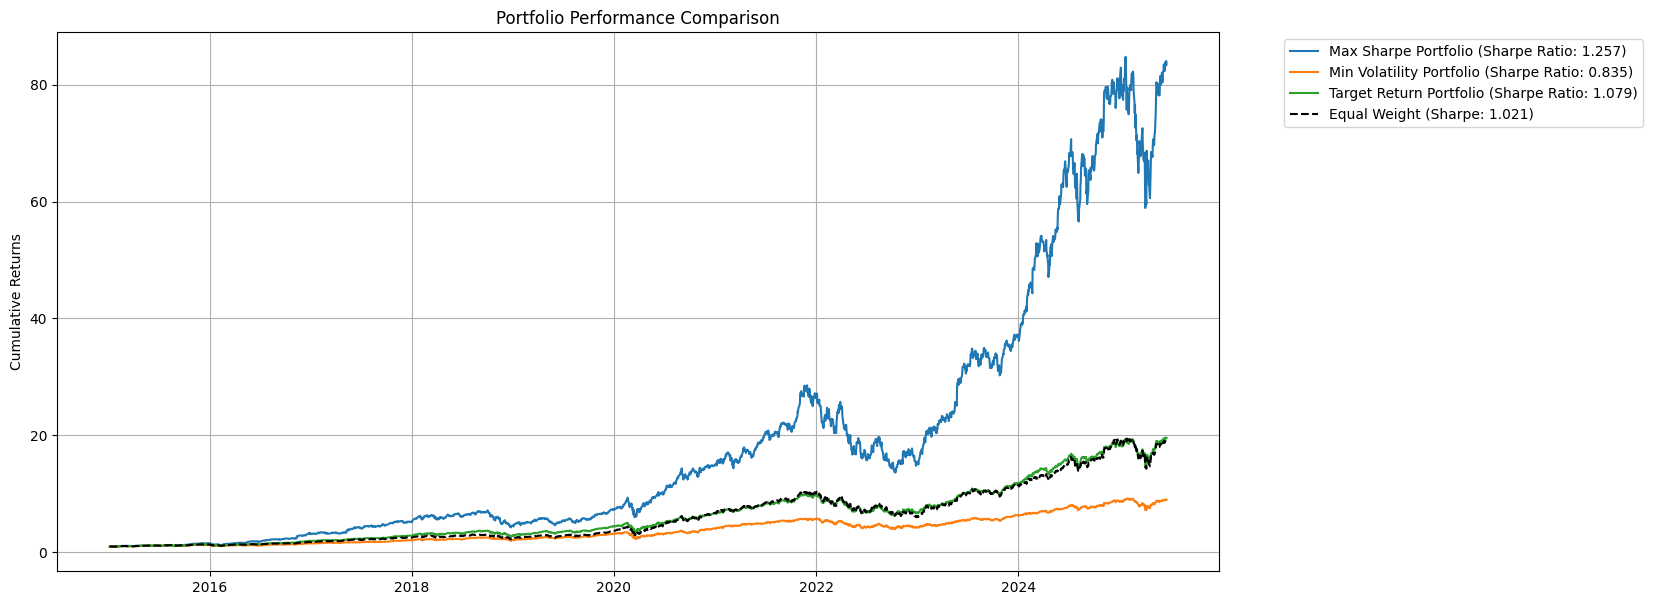

In [109]:
# Backtest all portfolios

results = {}
for name, weights in portfolios.items():
    stats = portfolio_stats(weights, returns)
    results[name] = {
            'Weights': weights,
            'Cumulative Returns': stats['cumulative_returns'],
            **{k: v for k, v in stats.items() if k != 'cumulative_returns'}
    }

plt.figure(figsize=(15, 7))
for name, stats in results.items():
    plt.plot(stats['Cumulative Returns'], label=f'{name} (Sharpe Ratio: {stats["sharpe_ratio"]:.3f})')

# naive equal weighted diversification
equal_weights = np.ones(len(returns.columns)) / len(returns.columns)
stats = portfolio_stats(equal_weights, returns)
plt.plot(stats['cumulative_returns'], 
         label=f'Equal Weight (Sharpe: {stats["sharpe_ratio"]:.3f})', 
         color='black', linestyle='--')

plt.title('Portfolio Performance Comparison')
plt.ylabel('Cumulative Returns')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

In [110]:
stats_df = pd.DataFrame({k: {m: v for m, v in res.items() if m != 'Weights' and m != 'Cumulative Returns'} 
                              for k, res in results.items()}).T
display(stats_df.style.background_gradient(cmap='YlGnBu'))

,annual_return,annual_volatility,sharpe_ratio,max_drawdown,sortino_ratio
Max Sharpe Portfolio,0.504417,0.335812,1.257020,-0.522965,1.713292
Min Volatility Portfolio,0.224338,0.220335,0.834585,-0.337705,1.064695
Target Return Portfolio,0.315851,0.241881,1.079171,-0.382116,1.382408


## Additional Notes

Calculated risk free rate brings sharpe down by ~0.4 units for some portfolios

### TODO

- use a better well diversified portfolio as done for Financial Econ Final Project
- Allow shorting